# Question 7: Logistic Regression versus Bayes Classifier

In [45]:
from scipy.stats import multivariate_normal
import numpy as np
class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        marginal_probs = cond_probs.dot(self.class_priors_)
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import zero_one_loss,log_loss,accuracy_score


In [48]:
breast_cancer = load_breast_cancer()

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, test_size=0.2)

In [50]:
lr = LogisticRegression().fit(x_train, y_train)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)

C:\Users\Ro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
train_01_loss = zero_one_loss(y_train, lr.predict(x_train))
test_01_loss = zero_one_loss(y_test, lr.predict(x_test))
train_log_loss = log_loss(y_train, nb.predict(x_train))
test_log_loss = log_loss(y_test, nb.predict(x_test))

In [66]:
models = [lr,nb,bc_shared,bc]
modelss = ['Linear Regression','Naives bayes', 'Shared Bayes classifier', 'Non shared Bayes classifier']
train_01_losses = []
train_log_losses = []
test_01_losses = []
test_log_losses = []

for model in models:
    train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
    train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
    test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
    test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

for x in range(4):
    print(f"{modelss[x]}: zero_one_loss train = {train_01_losses[x]}")
    print(f"log loss train = {train_log_losses[x]}")
    print(f"zero_one_loss test = {test_01_losses[x]}")
    print(f"log loss test = {test_log_losses[x]}")

Linear Regression: zero_one_loss train = 0.0461538461538461
log loss train = 0.10143694295348518
zero_one_loss test = 0.03508771929824561
log loss test = 0.08969387036595956
Naives bayes: zero_one_loss train = 0.06813186813186811
log loss train = 1.336410286298897
zero_one_loss test = 0.07894736842105265
log loss test = 1.0732409728887617
Shared Bayes classifier: zero_one_loss train = 0.03736263736263734
log loss train = 0.08872188255680871
zero_one_loss test = 0.07017543859649122
log loss test = 0.18275671838878596
Non shared Bayes classifier: zero_one_loss train = 0.0483516483516484
log loss train = 0.7622689028109904
zero_one_loss test = 0.03508771929824561
log loss test = 0.4325121706078324


The best model here is logistic regression as it has the best score overall.

In [69]:
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

training_sizes = range(5, 501, 5) 
num_repetitions = 10
results = []

for N in training_sizes:
    train_acc_lr = []
    test_acc_lr = []
    train_acc_nb = []
    test_acc_nb = []
    train_acc_bc_shared = []
    test_acc_bc_shared = []
    train_acc_bc = []
    test_acc_bc = []
    
    for _ in range(num_repetitions):
        X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, train_size=N, shuffle=True,stratify=breast_cancer.target)
        lr = LogisticRegression().fit(X_train, y_train)
        nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(X_train, y_train)
        bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(X_train, y_train)
        bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(X_train, y_train)
        
        y_train_pred_lr = lr.predict(X_train)
        y_test_pred_lr = lr.predict(X_test)
        
        y_train_pred_nb = nb.predict(X_train)
        y_test_pred_nb = nb.predict(X_test)
        
        y_train_pred_bc_shared = bc_shared.predict(X_train)
        y_test_pred_bc_shared = bc_shared.predict(X_test)
        
        y_train_pred_bc = bc.predict(X_train)
        y_test_pred_bc = bc.predict(X_test)
        
        train_accuracy_lr = accuracy_score(y_train, y_train_pred_nb)
        test_accuracy_lr = accuracy_score(y_test, y_test_pred_nb)
        
        train_accuracy_nb = accuracy_score(y_train, y_train_pred_lr)
        test_accuracy_nb = accuracy_score(y_test, y_test_pred_lr)
        
        train_accuracy_bc_shared = accuracy_score(y_train, y_train_pred_bc_shared)
        test_accuracy_bc_shared = accuracy_score(y_test, y_test_pred_bc_shared)
        
        train_accuracy_bc = accuracy_score(y_train, y_train_pred_bc)
        test_accuracy_bc = accuracy_score(y_test, y_test_pred_bc)
        
        train_acc_lr.append(train_accuracy_lr)
        test_acc_lr.append(test_accuracy_lr)
        
        train_acc_nb.append(train_accuracy_nb)
        test_acc_nb.append(test_accuracy_nb)
        
        train_acc_bc_shared.append(train_accuracy_bc_shared)
        test_acc_bc_shared.append(test_accuracy_bc_shared)
        
        train_acc_bc.append(train_accuracy_bc)
        test_acc_bc.append(test_accuracy_bc)
        
        mean_train_accuracy_lr = np.mean(train_acc_lr)
        std_train_accuracy_lr = np.std(train_acc_lr)
        mean_test_accuracy_lr = np.mean(test_acc_lr)
        std_test_accuracy_lr = np.std(test_acc_lr)
        
        mean_train_accuracy_nb = np.mean(train_acc_nb)
        std_train_accuracy_nb = np.std(train_acc_nb)
        mean_test_accuracy_nb = np.mean(test_acc_nb)
        std_test_accuracy_nb = np.std(test_acc_nb)
        
        mean_train_accuracy_bc_shared = np.mean(train_acc_bc_shared)
        std_train_accuracy_bc_shared = np.std(train_acc_bc_shared)
        mean_test_accuracy_bc_shared = np.mean(test_acc_bc_shared)
        std_test_accuracy_bc_shared = np.std(test_acc_bc_shared)
        
        mean_train_accuracy_bc = np.mean(train_acc_bc)
        std_train_accuracy_bc = np.std(train_acc_bc)
        mean_test_accuracy_bc = np.mean(test_acc_bc)
        std_test_accuracy_bc = np.std(test_acc_bc)
        
        results.append((N, mean_train_accuracy_lr, std_train_accuracy_lr, mean_test_accuracy_lr, std_test_accuracy_lr,
                       mean_train_accuracy_nb,std_train_accuracy_nb,mean_test_accuracy_nb,std_test_accuracy_nb,
                       mean_train_accuracy_bc_shared, std_train_accuracy_bc_shared,mean_test_accuracy_bc_shared,std_test_accuracy_bc_shared,
                       mean_train_accuracy_bc,std_train_accuracy_bc,mean_test_accuracy_bc,std_test_accuracy_bc
                       ))

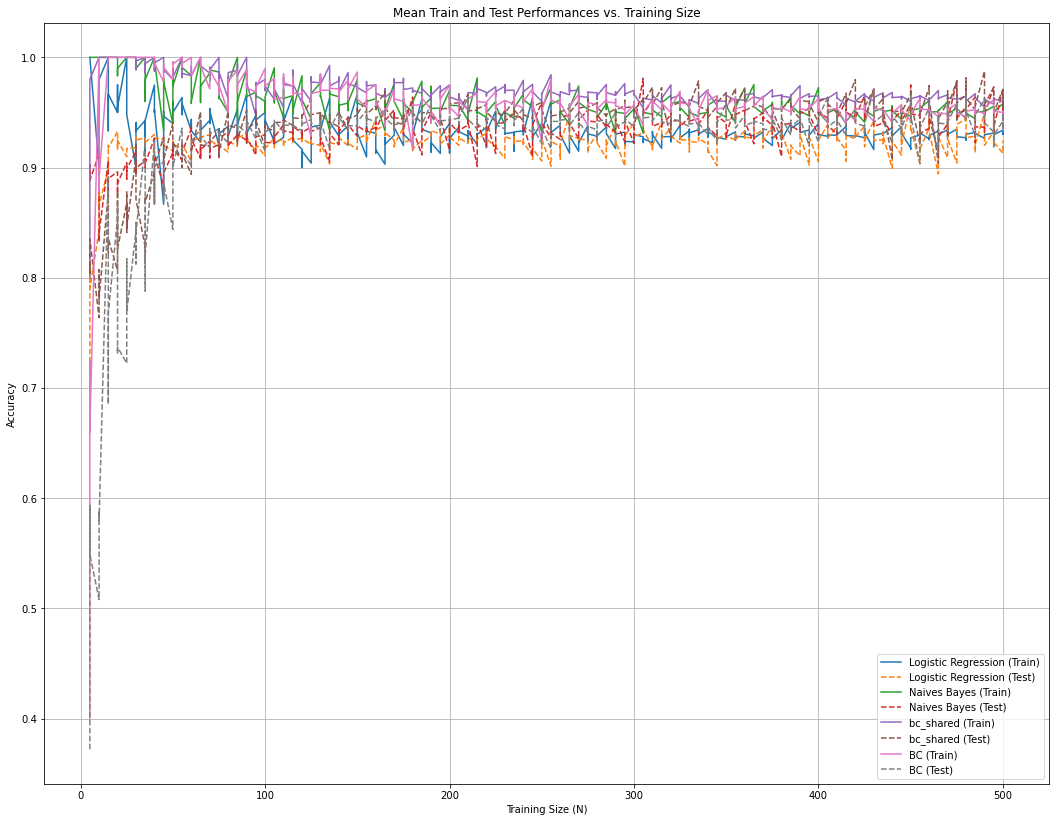

In [70]:
import matplotlib.pyplot as plt 

sizes = [result[0] for result in results]
mean_train_acc_lr = [result[1] for result in results]
mean_test_acc_lr = [result[3] for result in results]
mean_train_acc_nb = [result[5] for result in results]
mean_test_acc_nb = [result[7] for result in results]
mean_train_acc_bc_shared = [result[9] for result in results]
mean_test_acc_bc_shared = [result[11] for result in results]
mean_train_acc_bc = [result[13] for result in results]
mean_test_acc_bc = [result[15] for result in results]
plt.figure(figsize=(18, 14))
plt.plot(sizes, mean_train_acc_lr, label='Logistic Regression (Train)')
plt.plot(sizes, mean_test_acc_lr, label='Logistic Regression (Test)',linestyle='--')
plt.plot(sizes, mean_train_acc_nb, label='Naives Bayes (Train)')
plt.plot(sizes, mean_test_acc_nb, label='Naives Bayes (Test)',linestyle='--')
plt.plot(sizes, mean_train_acc_bc_shared, label='bc_shared (Train)')
plt.plot(sizes, mean_test_acc_bc_shared, label='bc_shared (Test)', linestyle='--')
plt.plot(sizes, mean_train_acc_bc, label='BC (Train)')
plt.plot(sizes, mean_test_acc_bc, label='BC (Test)', linestyle='--')
plt.xlabel('Training Size (N)')
plt.ylabel('Accuracy')
plt.title('Mean Train and Test Performances vs. Training Size')
plt.legend()
plt.grid()
plt.show()

When the number of training data points are increased:
The training errors decrease and the train errors increase as the size of the dataset increases.
1. Logistic Regression: Training performance typically improves wiht an increasing number of training data points. As the training set size increases the model has more data to learn from which helps it better to estimate tge underlying relationship between features and the target variable. Test performance also generally improves with more data. A largert training set can lead to more generalized model reducing overfitting and consequently improving performance.
2. Naive Bayes (without shared covariance): Training performance regardless of the dataset size often converges quickly during training. Increasing the number of training data points marginally imporve training performance as it helps refine probability estimates. For testing performance it can perform well witha small traning set if independence assumptions roughly hold. As the training set grows it does not benefit significantly from additional data because it doesn't capture complex dependencies between features.
3. Bayes classifier(with shared covariance): The training perofrmance requires more amount of data to estimate accurately. As the training set size increases the estimation becomes more reliable which improves performance. For testing performance when the training size is small the model doesnt perform as well but for larger training sets it is better in capturing relationships between features leading to improved performance. 
4. Bayes classifier(with full covariance, not shared): For training performance it also requires a larger training set to estimate individual covariances accurately. As the training size increases it becomes more reliable and hence improving training performance. For the testing performance when the trainin set is small it does not perform as well due to inaccirate covariance estimation. However with larger data sets the performance improves. 

Best suited classifiers based on training set size:
1. When the training size is small then the best suited classifier is the Naive Bayes because it has a simple model with fewer parameters and so performs well when the data is limited. Its strong independence assmptions make it less prone to overfitting with a small dataset. 
2. For large training set size the best suited classifier is the bayes classifier full covariance shared as it can capture complex relationships in the data with large amounts of data. Logistic Regression can handle large datasets well and benefit from the abundance of data to generalize effectively. 

The justifications:
1. Logistic Regression tends to perform well with larger datasets because with it it can handle high model complexity and learn intricate patterns. Also it is less likely to overfit and can generalize better. 
2. Naives Bayes is suitable for small datasets due to its simplicity and strong independence assumptions. With limited data its less prone to overfitting and provide good results. 
3. Bayes classifier with full covariance (shared and not shared) can capture complex dependencies between features but require larger datasets to estimate covariance matrices accurately. With smaller datasets these models struggle to estimate the covariances correctly leading to suboptimal performance. As the dataset size grows they perform well due to their ability to capture more intricate relationships. 